In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from IPython.display import display, HTML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from itertools import cycle



In [2]:
df = pd.read_csv('HeartAttack.csv')
# Removing column 'group' as it is not required
df = df.drop(columns=['group'])
# Removing rows with any NaN values
df_cleaned = df.dropna()
print(df_cleaned.head(10))

   sub-type  Age  Gender    WBC   RBC   HGB    BA    EO    LY    MO  ...  \
0         2   28       1  10.90  5.09  15.3  0.06  0.19  2.77  0.96  ...   
1         2   40       0   5.96  5.16  15.6  0.03  0.37  2.36  0.43  ...   
2         2   64       1   4.59  5.51  14.9  0.05  0.05  1.12  0.27  ...   
3         2   57       0   7.26  4.70  12.5  0.05  0.11  3.46  0.70  ...   
4         2   58       0   7.15  4.37  12.1  0.03  0.34  1.90  0.47  ...   
5         2   47       1   8.40  4.55  13.4  0.05  0.11  3.60  0.70  ...   
6         2   59       0   4.65  4.99  13.9  0.02  0.10  1.85  0.35  ...   
7         2   63       0   5.59  4.23  11.8  0.01  0.12  1.47  0.37  ...   
8         2   45       1   5.90  5.28  15.0  0.01  0.10  2.40  0.60  ...   
9         2   37       0   8.58  4.57  13.7  0.04  0.12  1.90  0.67  ...   

     MPV  PLT   HCT   MCV  RDW-SD  RDW-CV   MCH  MCHC   PDW    PCT  
0  10.00  309  46.3  91.9    58.0    11.5  30.1  33.0  11.20  0.31  
1  13.30  214  45.9  89.0

In [3]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sub-type  981 non-null    int64  
 1   Age       981 non-null    int64  
 2   Gender    981 non-null    int64  
 3   WBC       981 non-null    float64
 4   RBC       981 non-null    float64
 5   HGB       981 non-null    float64
 6   BA        981 non-null    float64
 7   EO        981 non-null    float64
 8   LY        981 non-null    float64
 9   MO        981 non-null    float64
 10  NEU       981 non-null    float64
 11  NEU/LY    981 non-null    float64
 12  PLT/LY    981 non-null    float64
 13  MPV/LY    981 non-null    float64
 14  LY/MO     981 non-null    float64
 15  MPV       981 non-null    float64
 16  PLT       981 non-null    int64  
 17  HCT       981 non-null    float64
 18  MCV       981 non-null    float64
 19  RDW-SD    981 non-null    float64
 20  RDW-CV    981 non-null    float6

# creating the correlation matrix and implementing the PCA in order to reduce the features count

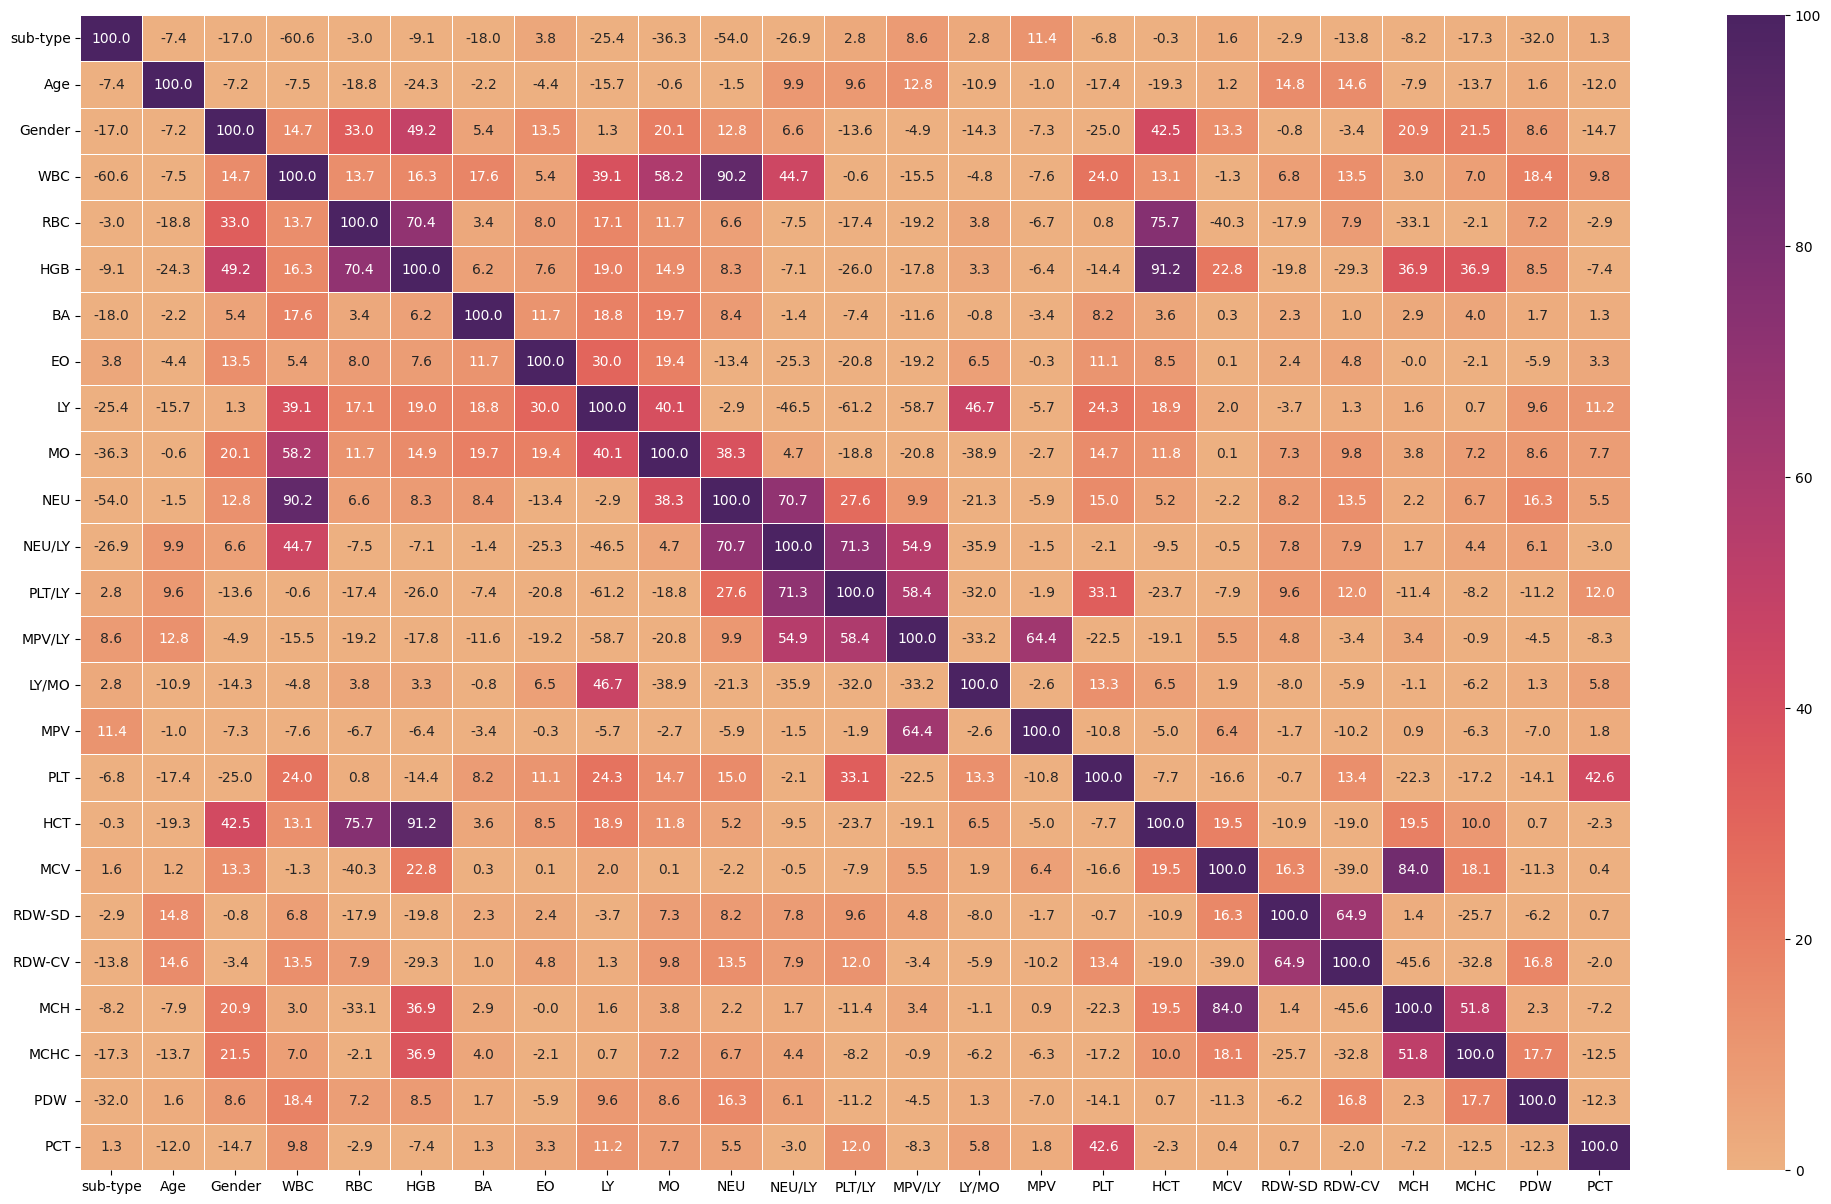

In [4]:

matrix = df_cleaned.corr() * 100

plt.figure(figsize=(25,15))
sns.heatmap(matrix, annot=True, linewidth=.5, vmin=0, vmax=100,
            fmt=".1f", cmap=sns.color_palette("flare", as_cmap=True))
plt.show()

In [5]:
copy_columns = df_cleaned.columns[1:]
X = df_cleaned[copy_columns].copy()
y = df_cleaned['sub-type']


In [6]:
# Scale the data before PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)
scaled_data_df

,Age,Gender,WBC,RBC,HGB,BA,EO,LY,MO,NEU,...,MPV,PLT,HCT,MCV,RDW-SD,RDW-CV,MCH,MCHC,PDW,PCT
0,-2.873600,0.852709,0.565289,0.612289,0.985156,0.060778,0.186459,0.237688,1.150782,0.174486,...,0.052867,0.692371,1.205635,0.923350,3.994687,-1.583841,0.458232,-0.280849,-0.785670,0.409944
1,-1.767169,-1.172733,-0.978413,0.740411,1.175517,-0.416210,1.459656,-0.111359,-0.881921,-1.039192,...,1.009640,-0.643229,1.113795,0.408502,-0.362630,-0.927032,0.500078,0.366685,2.904788,0.188412
2,0.445693,0.852709,-1.406524,1.381022,0.731341,-0.098218,-0.803806,-1.167015,-1.495567,-0.923101,...,0.342799,-0.938467,0.631635,-1.278070,-0.907295,-0.197244,-0.838980,0.366685,0.034432,-0.328497
3,-0.199725,-1.172733,-0.572175,-0.101535,-0.791548,-0.098218,-0.379407,0.825110,0.153607,-0.979387,...,0.052867,0.861079,-0.194926,-0.212867,1.023789,0.824460,-1.843274,-0.863630,-0.546473,0.483788
4,-0.107523,-1.172733,-0.606549,-0.705540,-1.045362,-0.416210,1.247457,-0.502973,-0.728509,-0.462255,...,-0.037011,-0.713524,-0.700047,0.053434,1.518939,1.043396,3.638495,-1.057890,-0.717328,-0.402341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,-1.490561,0.852709,0.312172,0.905140,1.175517,-0.416210,-0.379407,0.459035,-0.536745,0.237808,...,-0.382029,-0.010576,0.493875,-0.780975,-0.214085,0.094672,0.290850,1.726507,0.786192,-0.254653
977,-0.107523,0.852709,1.634005,1.069868,0.794795,0.855760,1.035257,0.714436,3.030073,1.191161,...,0.081860,-0.460463,0.585715,-0.124100,-0.907295,-0.416180,-0.378679,0.625699,-0.648986,-0.180809
978,0.261288,0.852709,0.171551,-0.906875,0.096804,-0.098218,-1.086739,-1.413902,-1.035332,0.927318,...,0.313805,-1.247764,-0.355646,1.029870,0.404852,-0.635117,1.504372,1.143726,-0.033910,-0.476185
979,-1.029548,-1.172733,0.749658,-1.291242,-0.728094,1.014756,-0.733073,0.901730,-0.114863,0.554420,...,-0.063105,0.692371,-0.748263,1.136390,-0.362630,-1.218947,0.834842,-0.093064,-1.161549,0.336100


In [7]:
# n_components can also be a percentage indicating the percentage of explained variance you want to capture
pca1 = PCA(n_components=0.85,random_state=42)
pca_data = pca1.fit_transform(scaled_data)
pca_data

array([[ 1.87881236,  1.26246561, -0.19551629, ..., -1.23214976,
        -0.98394095, -1.20283573],
       [ 1.80007253, -1.04028044,  1.59500823, ..., -2.17739013,
        -0.88498747,  0.17870209],
       [-0.5824935 , -0.3179658 ,  1.64737027, ..., -0.26781428,
         0.58675463, -0.10373774],
       ...,
       [-2.31882486,  3.09010982,  3.26146279, ..., -0.36119146,
         0.41469584,  0.16252786],
       [ 0.23790249, -0.67324402,  0.09560597, ...,  0.50704371,
         0.92333382, -0.71113142],
       [-1.25478215, -1.5268964 ,  1.10860276, ...,  0.30894543,
        -0.29620616, -0.31716158]])

In [8]:
pca1.explained_variance_ratio_

array([0.16661254, 0.13129038, 0.12507875, 0.0892193 , 0.07319929,
       0.06036165, 0.0555553 , 0.04879199, 0.03877396, 0.03824053,
       0.03416512])

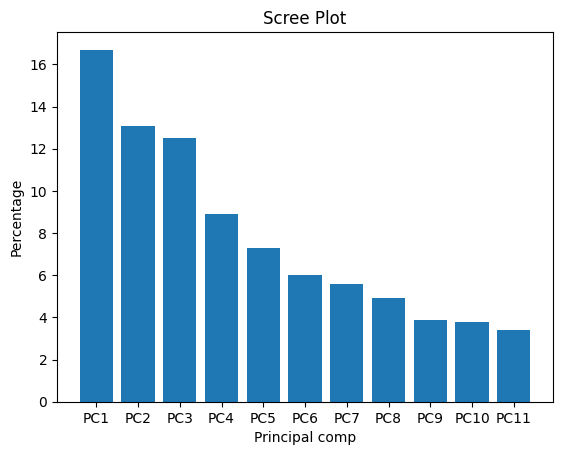

In [9]:
# Multiply explained by 100 and round
per_var = np.round(pca1.explained_variance_ratio_ * 100, decimals=1)
# Create labels for barplot
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]


plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)

plt.ylabel('Percentage')

plt.xlabel('Principal comp')

plt.title('Scree Plot')

plt.show()

In [10]:
sum(pca1.explained_variance_ratio_)

0.861288827273476

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [85.0%] explained variance using the [24] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [85.00%] explained variance.
[pca] >The PCA reduction is performed on the [24] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot
[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


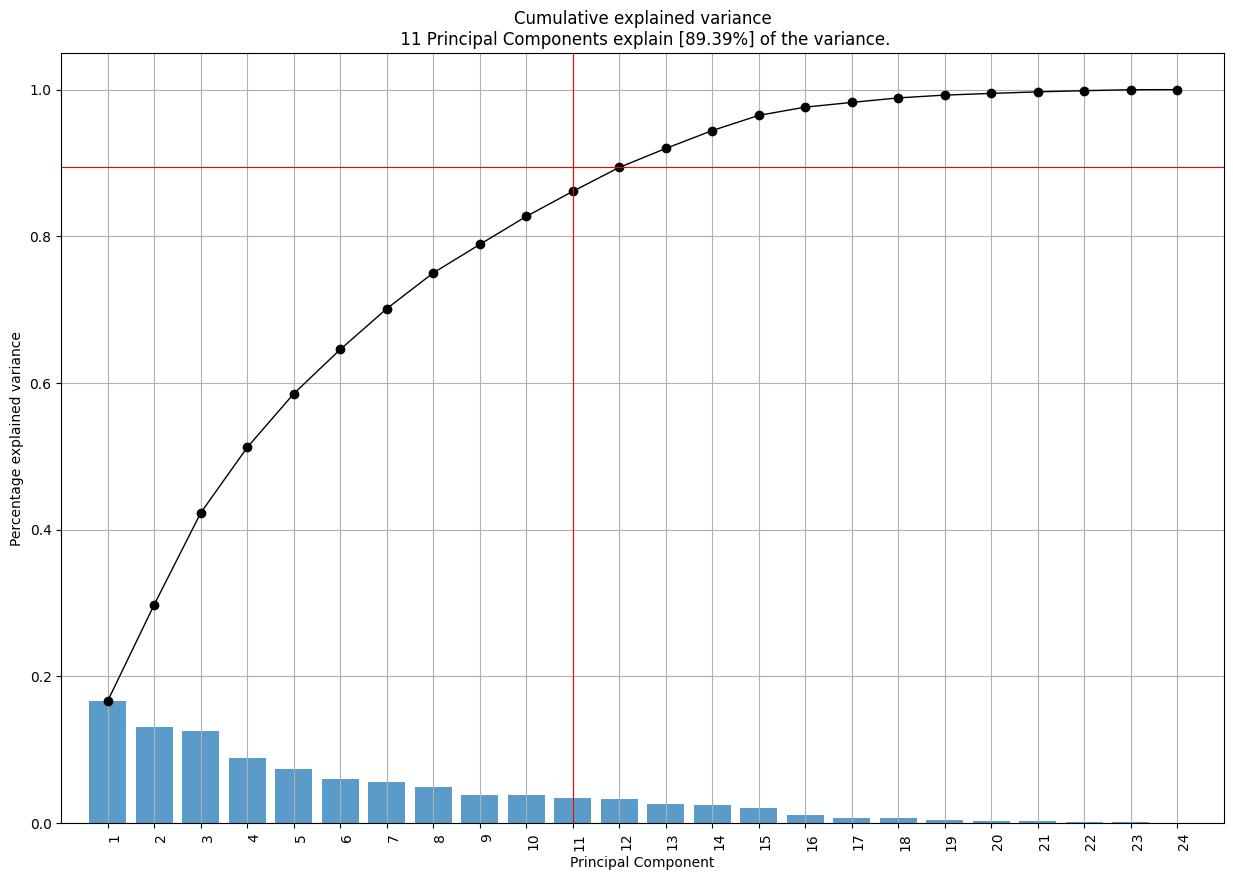

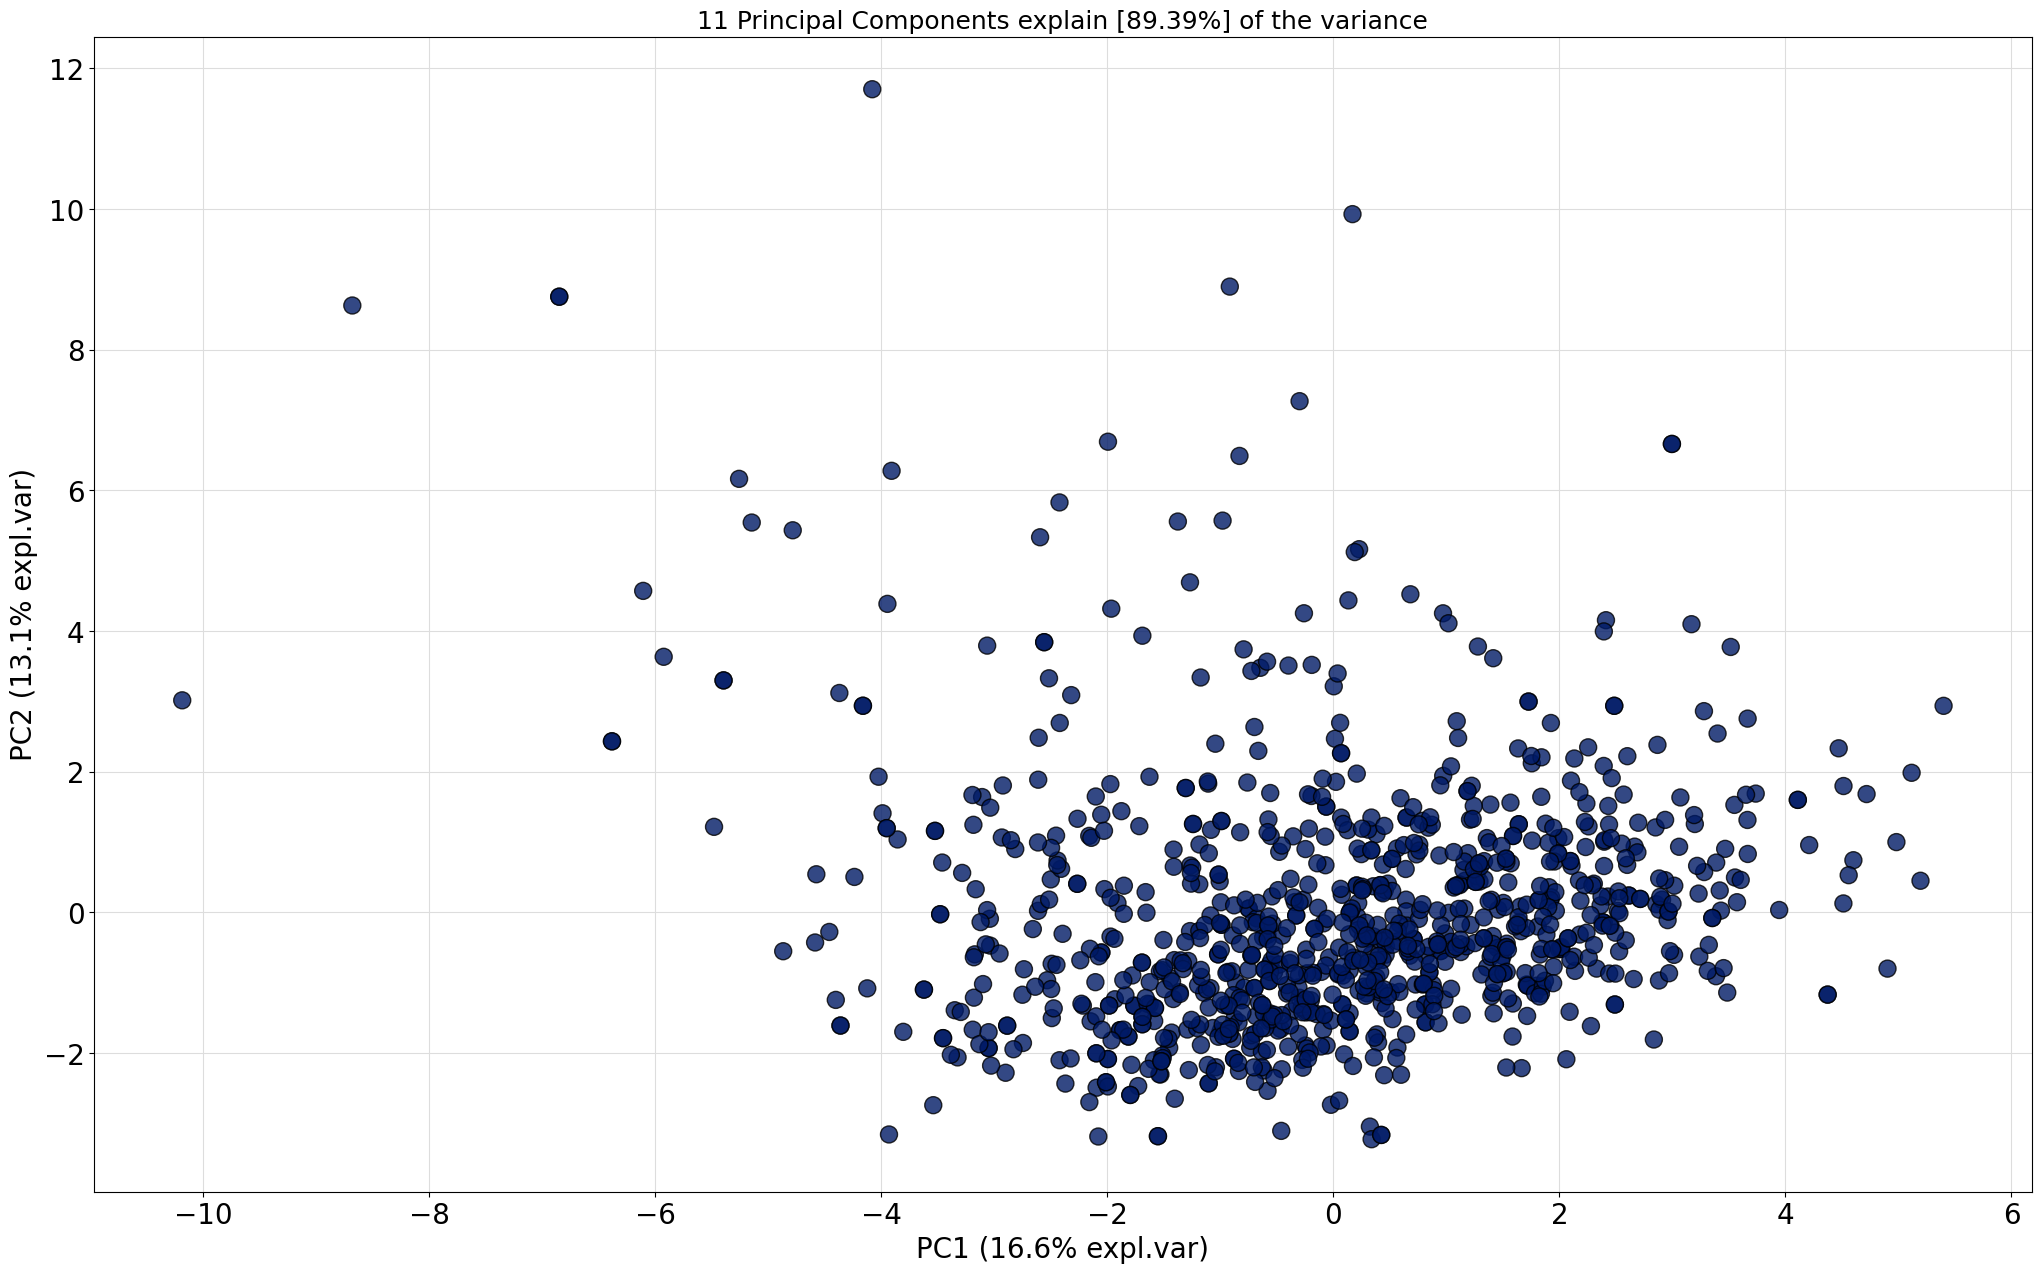

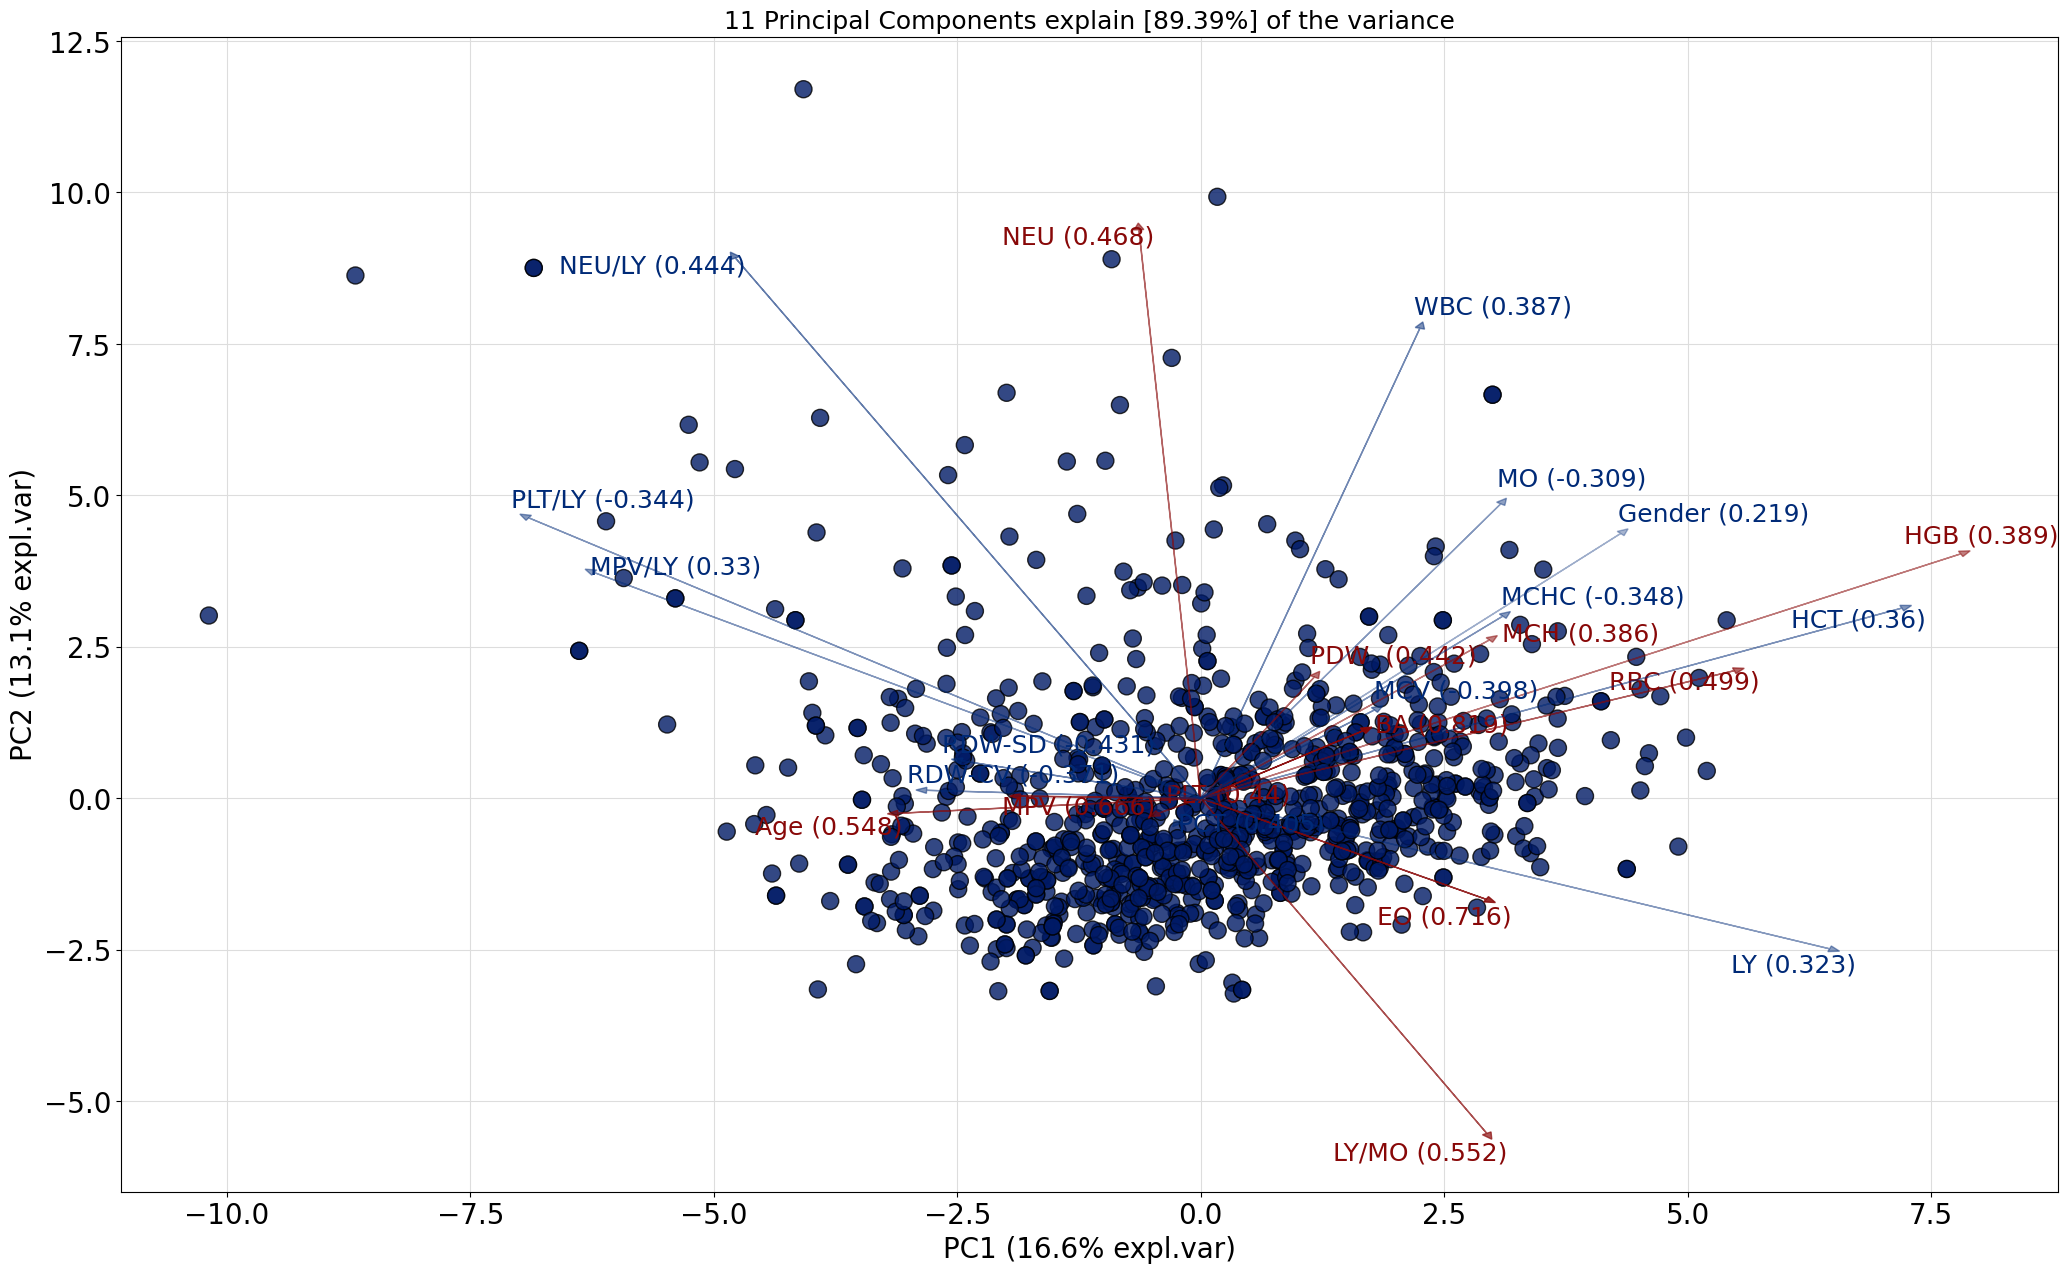

In [11]:
from pca import pca
#scaled_data_df = pd.DataFrame(scaled_data, columns=data.columns)
###########################################################
# COMPUTE AND VISUALIZE PCA
###########################################################
# Initialize the PCA
model = pca(n_components=0.85)

# Fit and transform
results = model.fit_transform(X=scaled_data_df)

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()

# Create a biplot
fig, ax = model.biplot()

In [12]:
pca_df = pd.DataFrame(pca_data, columns=labels)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,1.878812,1.262466,-0.195516,-0.833162,0.172783,-3.102098,-0.954263,0.233902,-1.232150,-0.983941,-1.202836
1,1.800073,-1.040280,1.595008,0.943560,0.523177,0.435807,0.882538,1.438984,-2.177390,-0.884987,0.178702
2,-0.582494,-0.317966,1.647370,3.572777,0.239799,0.340456,0.145956,-0.005258,-0.267814,0.586755,-0.103738
3,-0.615601,-2.246860,-1.988319,0.054678,0.069171,-0.796045,-0.121876,0.305761,0.206137,-0.249142,-0.881842
4,-1.142697,-1.143459,1.153539,-1.775222,-1.416274,-1.394322,-0.865355,0.328994,-0.663004,-0.250010,0.674821
...,...,...,...,...,...,...,...,...,...,...,...
976,2.223478,0.387819,0.128680,0.863519,0.356956,1.294772,-0.579741,0.866430,-1.393134,-0.613676,0.033922
977,2.601523,2.222001,-1.318976,-0.318585,-0.336266,-0.045751,1.846025,-1.695558,0.926157,-0.033310,0.066977
978,-2.318825,3.090110,3.261463,-0.260394,-0.283354,0.150760,-0.322202,0.579047,-0.361191,0.414696,0.162528
979,0.237902,-0.673244,0.095606,-2.856853,1.662890,0.301925,0.063032,0.407092,0.507044,0.923334,-0.711131


# Simple Multinomial Logistic Regression model using PCA data

Accuracy: 66.49746192893402
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.43      0.50        37
           1       0.50      0.39      0.44        61
           2       0.75      0.92      0.82        99

    accuracy                           0.66       197
   macro avg       0.61      0.58      0.59       197
weighted avg       0.64      0.66      0.64       197



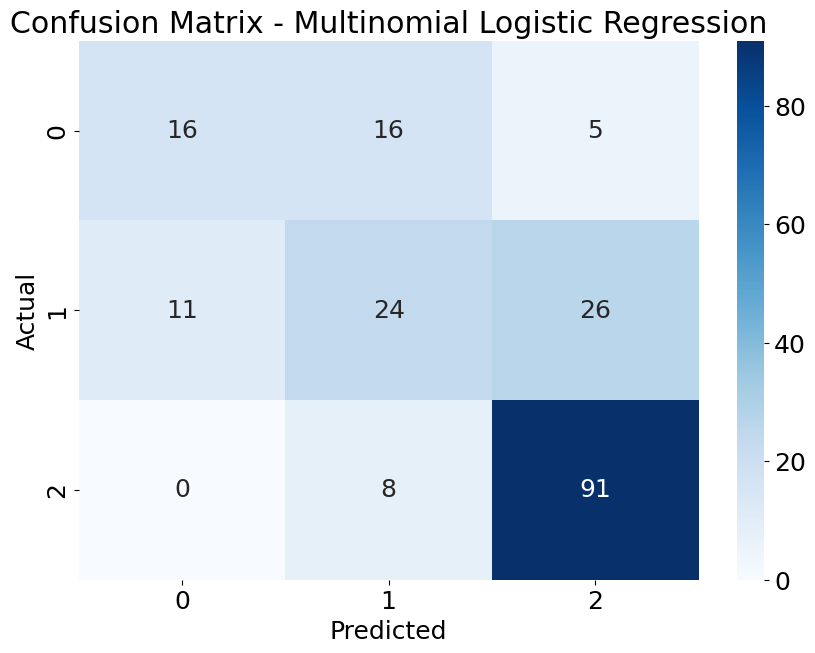

In [13]:
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Splitting the data into features and target
X_PCA = pca_df.copy()


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.2, random_state=42)

# Creating the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy*100)
print("Classification Report:\n", report)

# plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix , annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multinomial Logistic Regression')
#plt.suptitle()
plt.show()


# Using the GridSearch to find best combination of hyperparameter of the model

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Best parameters found:  {'C': 1, 'max_iter': 100, 'solver': 'newton-cg'}
Accuracy: 66.49746192893402
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.43      0.50        37
           1       0.50      0.39      0.44        61
           2       0.75      0.92      0.82        99

    accuracy                           0.66       197
   macro avg       0.61      0.58      0.59       197
weighted avg       0.64      0.66      0.64       197



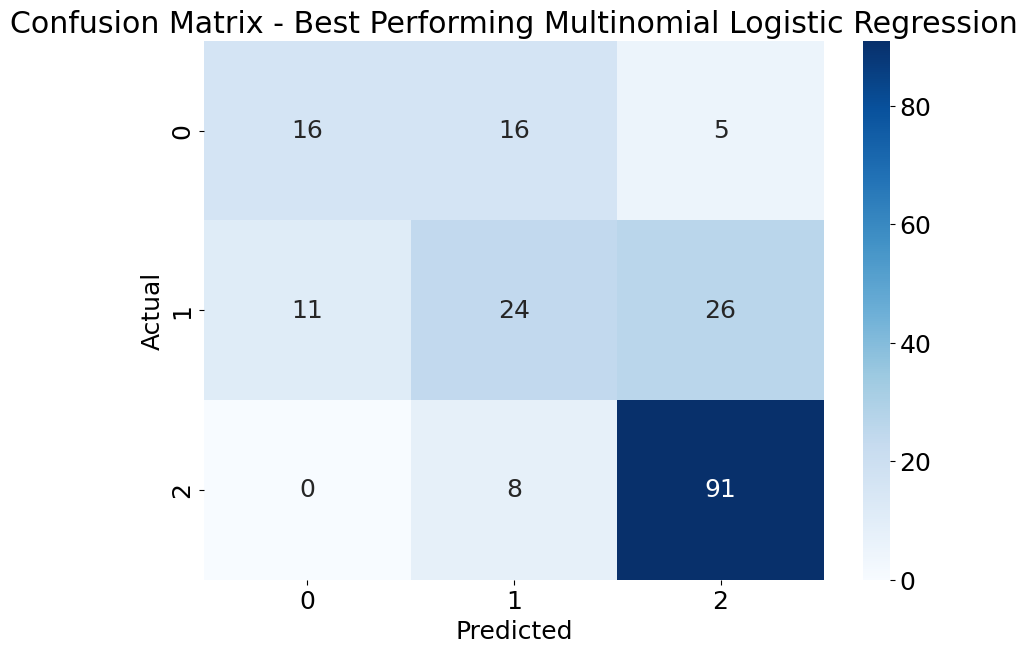

In [15]:
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'max_iter': [100, 200, 300]
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(multi_class='multinomial', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best model
best_logreg_model = grid_search.best_estimator_

# Make predictions
y_pred = best_logreg_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix_best = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy*100)
print("Classification Report:\n", report)
#print("Confusion Matrix:\n", conf_matrix)

# plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best , annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Performing Multinomial Logistic Regression')
#plt.suptitle()
plt.show()


### There is no change in the results when we use the GridSearchCV techinique to find the best hyperparameters for Multinomial Logistic Regression model.

# Implementing the Multinomial Logistic regression,SVC,Decision Tree,Random Forest and XGBOOST with optimization techinique cross validation

Average Logistic Regression Accuracy: 0.6778514451465866
Average SVC Accuracy: 0.678861493836113
Average Decision Tree Accuracy: 0.6268672951414069
Average Random Forest Accuracy: 0.700269346317207
Average XGBoost Accuracy: 0.7186418729928519


Average Logistic Regression AUC: 0.8341880349158709
Average SVC AUC: 0.8401661847561688
Average Decision Tree AUC: 0.746717916623364
Average Random Forest AUC: 0.8580907055780024
Average XGBoost AUC: 0.8723805806891249


Logistic Regression Accuracy Score: 0.6901121304791029
SVC Accuracy Score: 0.6992864424057085
Decision Tree Classifier Accuracy Score: 0.8583078491335372
Random Forest Classifier Accuracy Score: 0.9327217125382263
XGBoost Accuracy Score: 1.0

 Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.48      0.56       182
           1       0.53      0.48      0.50       295
           2       0.77      0.89      0.82       504

    accuracy                           0.69       981
   macro avg       0.66      0.62      0.63       981
weighted avg       0.68      0.69      0.68       981

Logistic Regression Hyperparameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


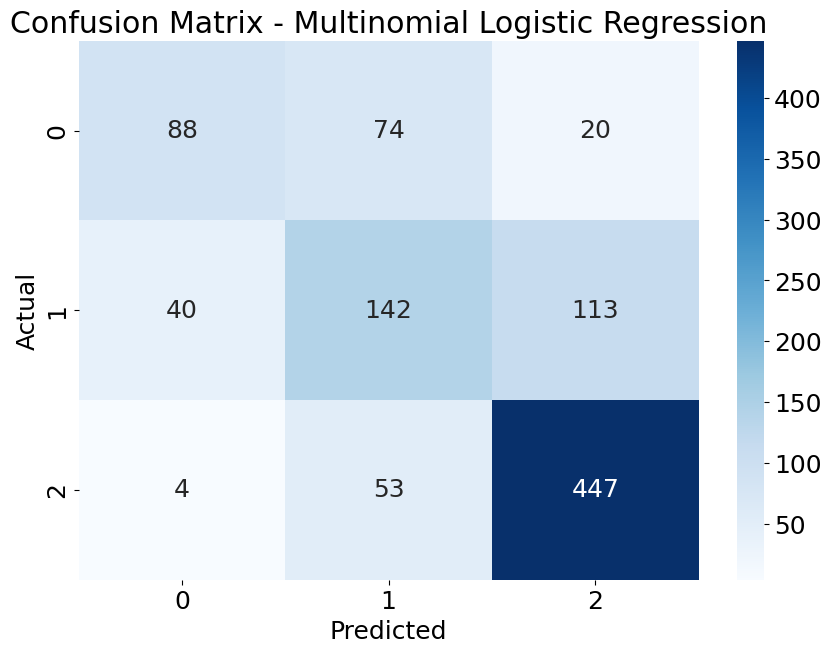

SVC Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.46      0.54       182
           1       0.55      0.51      0.53       295
           2       0.78      0.90      0.84       504

    accuracy                           0.70       981
   macro avg       0.66      0.62      0.63       981
weighted avg       0.69      0.70      0.69       981

SVC Hyperparameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


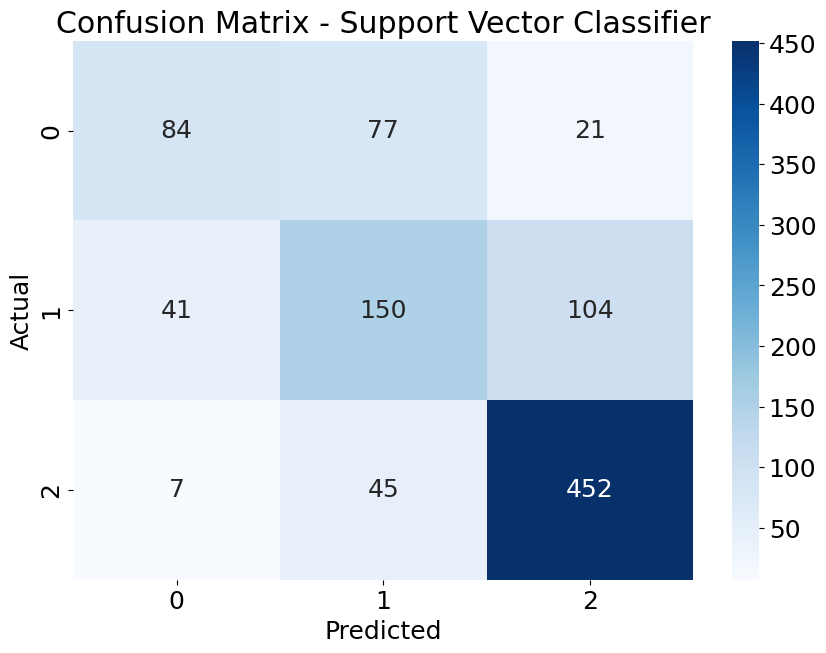

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.79       182
           1       0.80      0.83      0.82       295
           2       0.91      0.91      0.91       504

    accuracy                           0.86       981
   macro avg       0.84      0.83      0.84       981
weighted avg       0.86      0.86      0.86       981

Decision Tree Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


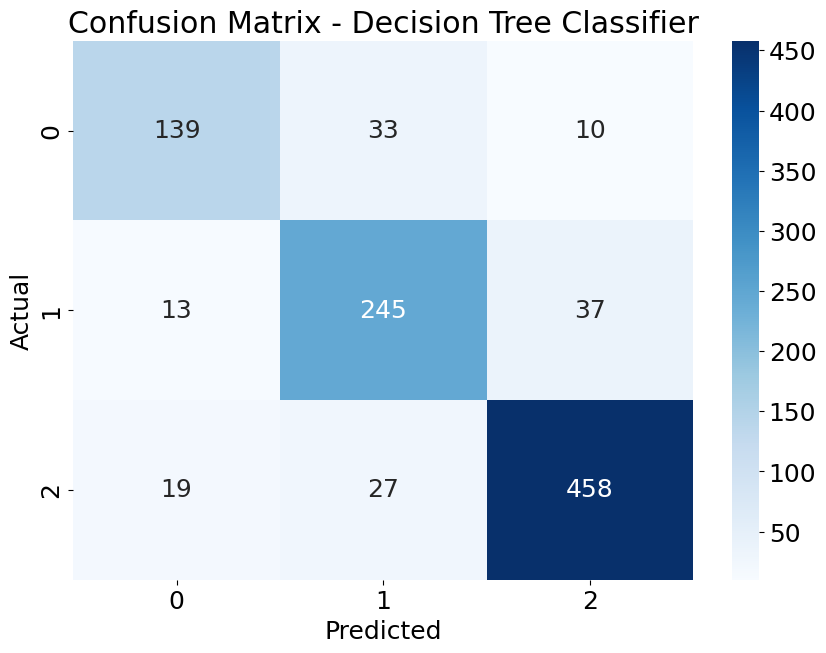

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       182
           1       0.97      0.85      0.91       295
           2       0.90      0.99      0.94       504

    accuracy                           0.93       981
   macro avg       0.95      0.91      0.93       981
weighted avg       0.94      0.93      0.93       981

Random Forest Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


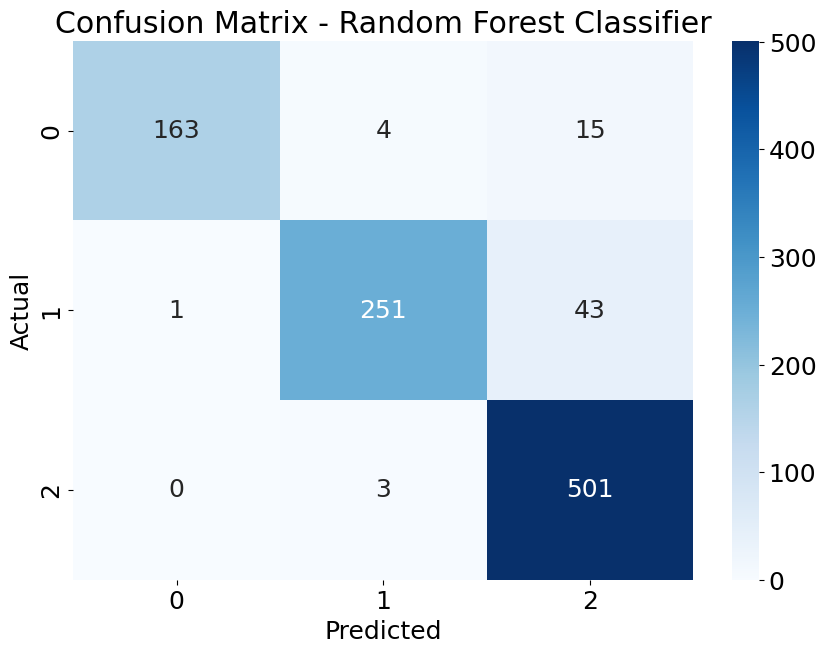

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       295
           2       1.00      1.00      1.00       504

    accuracy                           1.00       981
   macro avg       1.00      1.00      1.00       981
weighted avg       1.00      1.00      1.00       981

XGBoost Hyperparameters: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight'

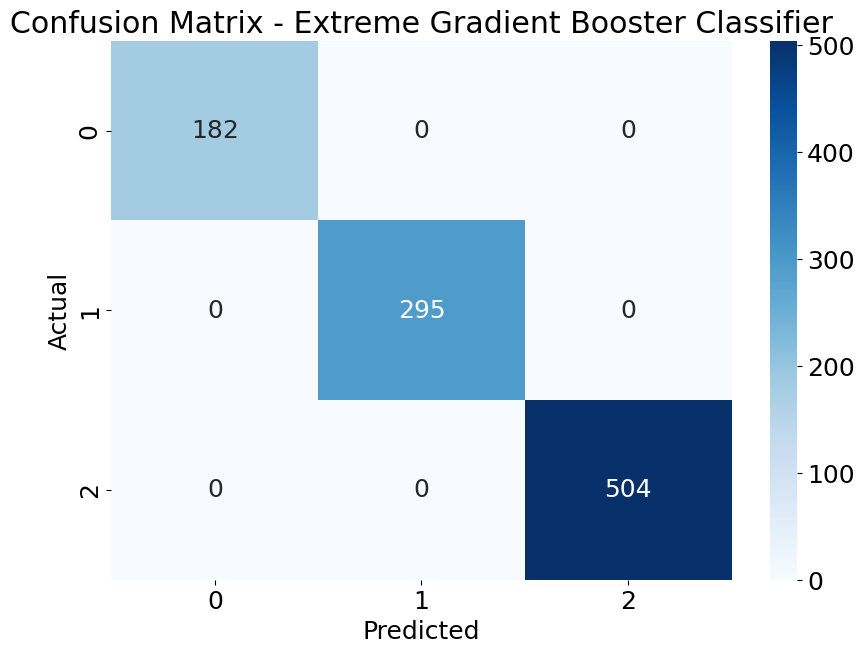

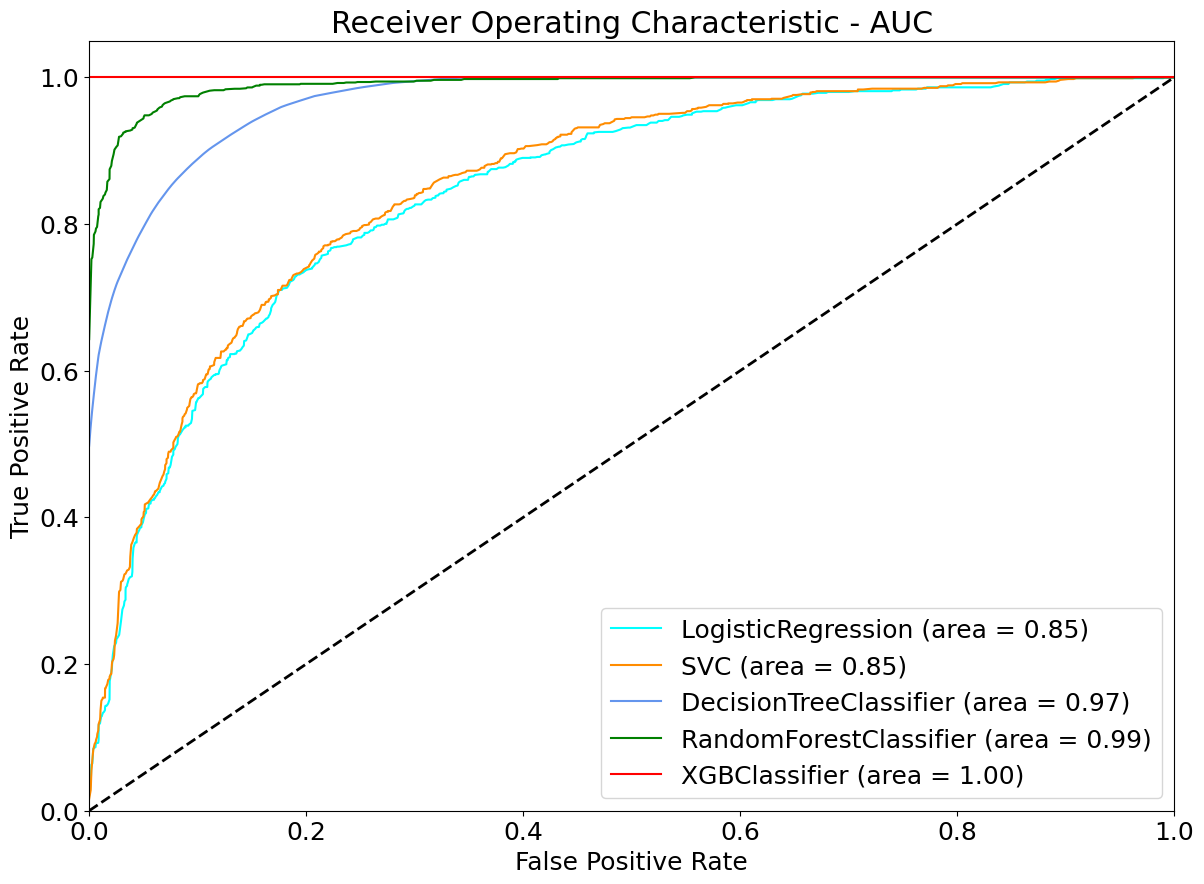

In [20]:

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

X_pca = pca_data.copy()
# Define the k-fold cross-validation strategy
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the models with hyperparameters
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000, C=1.0)  # L2 regularization with C parameter
svc_model = SVC(kernel='linear', probability=True, C=1.0)  # Regularization with C parameter
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5)  # Regularization with tree parameters
forest_model = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=10, min_samples_leaf=5)  # Regularization with tree parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, reg_alpha=0.1, reg_lambda=1.0)  # L1 and L2 regularization

# Lists to store evaluation metrics for each fold
logistic_accuracies = []
svc_accuracies = []
tree_accuracies = []
forest_accuracies = []
xgb_accuracies = []

logistic_aucs = []
svc_aucs = []
tree_aucs = []
forest_aucs = []
xgb_aucs = []

# Perform k-fold cross-validation
for train_index, test_index in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Logistic Regression
    logistic_model.fit(X_train, y_train)
    y_pred_logistic = logistic_model.predict(X_test)
    y_prob_logistic = logistic_model.predict_proba(X_test)
    logistic_accuracies.append(accuracy_score(y_test, y_pred_logistic))
    logistic_aucs.append(roc_auc_score(y_test, y_prob_logistic, multi_class='ovr'))
    
    # SVC
    svc_model.fit(X_train, y_train)
    y_pred_svc = svc_model.predict(X_test)
    y_prob_svc = svc_model.predict_proba(X_test)
    svc_accuracies.append(accuracy_score(y_test, y_pred_svc))
    svc_aucs.append(roc_auc_score(y_test, y_prob_svc, multi_class='ovr'))
    
    # Decision Tree
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    y_prob_tree = tree_model.predict_proba(X_test)
    tree_accuracies.append(accuracy_score(y_test, y_pred_tree))
    tree_aucs.append(roc_auc_score(y_test, y_prob_tree, multi_class='ovr'))
    
    # Random Forest
    forest_model.fit(X_train, y_train)
    y_pred_forest = forest_model.predict(X_test)
    y_prob_forest = forest_model.predict_proba(X_test)
    forest_accuracies.append(accuracy_score(y_test, y_pred_forest))
    forest_aucs.append(roc_auc_score(y_test, y_prob_forest, multi_class='ovr'))
    
    # XGBoost
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    y_prob_xgb = xgb_model.predict_proba(X_test)
    xgb_accuracies.append(accuracy_score(y_test, y_pred_xgb))
    xgb_aucs.append(roc_auc_score(y_test, y_prob_xgb, multi_class='ovr'))

# Average accuracy and AUC across all folds
avg_logistic_accuracy = np.mean(logistic_accuracies)
avg_svc_accuracy = np.mean(svc_accuracies)
avg_tree_accuracy = np.mean(tree_accuracies)
avg_forest_accuracy = np.mean(forest_accuracies)
avg_xgb_accuracy = np.mean(xgb_accuracies)

avg_logistic_auc = np.mean(logistic_aucs)
avg_svc_auc = np.mean(svc_aucs)
avg_tree_auc = np.mean(tree_aucs)
avg_forest_auc = np.mean(forest_aucs)
avg_xgb_auc = np.mean(xgb_aucs)

display(HTML(f"<h2>Average Accuracies of Models on Test Data </h2>"))

print(f"Average Logistic Regression Accuracy: {avg_logistic_accuracy}")
print(f"Average SVC Accuracy: {avg_svc_accuracy}")
print(f"Average Decision Tree Accuracy: {avg_tree_accuracy}")
print(f"Average Random Forest Accuracy: {avg_forest_accuracy}")
print(f"Average XGBoost Accuracy: {avg_xgb_accuracy}")

display(HTML(f"<h2>Average AUCs of Models on Test Data </h2>"))
print(f"Average Logistic Regression AUC: {avg_logistic_auc}")
print(f"Average SVC AUC: {avg_svc_auc}")
print(f"Average Decision Tree AUC: {avg_tree_auc}")
print(f"Average Random Forest AUC: {avg_forest_auc}")
print(f"Average XGBoost AUC: {avg_xgb_auc}")

# Fit the models on the entire dataset and get final evaluation metrics
display(HTML(f"<h2>Fit the models on the entire dataset and display final evaluation metrics</h2>"))
logistic_model.fit(X_pca, y)
svc_model.fit(X_pca, y)
tree_model.fit(X_pca, y)
forest_model.fit(X_pca, y)
xgb_model.fit(X_pca, y)

y_pred_logistic = logistic_model.predict(X_pca)
y_prob_logistic = logistic_model.predict_proba(X_pca)
y_pred_svc = svc_model.predict(X_pca)
y_prob_svc = svc_model.predict_proba(X_pca)
y_pred_tree = tree_model.predict(X_pca)
y_prob_tree = tree_model.predict_proba(X_pca)
y_pred_forest = forest_model.predict(X_pca)
y_prob_forest = forest_model.predict_proba(X_pca)
y_pred_xgb = xgb_model.predict(X_pca)
y_prob_xgb = xgb_model.predict_proba(X_pca)

# Final evaluation
display(HTML(f"<h3><i>Average Accuracies ,Confusion matrix,Hyperparameters of Models on Entire Data </i></h3>"))

display(HTML(f"<h2>Average Accuracies of Models on Entire Data </h2>"))
print("Logistic Regression Accuracy Score:", accuracy_score(y, y_pred_logistic))
print("SVC Accuracy Score:", accuracy_score(y, y_pred_svc))
print("Decision Tree Classifier Accuracy Score:", accuracy_score(y, y_pred_tree))
print("Random Forest Classifier Accuracy Score:", accuracy_score(y, y_pred_forest))
print("XGBoost Accuracy Score:", accuracy_score(y, y_pred_xgb))

print("\nLogistic Regression Classification Report:\n", classification_report(y, y_pred_logistic))
print("Logistic Regression Hyperparameters:", logistic_model.get_params())

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y, y_pred_logistic), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multinomial Logistic Regression')
plt.show()

print("SVC Classification Report:\n", classification_report(y, y_pred_svc))
print("SVC Hyperparameters:", svc_model.get_params())

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y, y_pred_svc), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Classifier')
plt.show()

print("Decision Tree Classification Report:\n", classification_report(y, y_pred_tree))
print("Decision Tree Hyperparameters:", tree_model.get_params())

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y, y_pred_tree), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

print("Random Forest Classification Report:\n", classification_report(y, y_pred_forest))
print("Random Forest Hyperparameters:", forest_model.get_params())

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y, y_pred_forest), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

print("XGBoost Classification Report:\n", classification_report(y, y_pred_xgb))
print("XGBoost Hyperparameters:", xgb_model.get_params())

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Extreme Gradient Booster Classifier')
plt.show()

display(HTML(f"<h3><i>Average AUCs of Models on Entire Data </i></h3>"))

# Plot ROC-AUC curves for all models
def plot_roc_curve(models, X, y):
    plt.figure(figsize=(14, 10))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

    for model, color in zip(models, colors):
        y_prob = model.predict_proba(X)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y.shape[1])]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(y.shape[1]):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= y.shape[1]
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        plt.plot(fpr["macro"], tpr["macro"], color=color,
                 label=f'{model.__class__.__name__} (area = {roc_auc["macro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - AUC')
    plt.legend(loc="lower right")
    plt.show()

# One-hot encode the labels
y_one_hot = pd.get_dummies(y).values

# Plot ROC curves for all models
plot_roc_curve([logistic_model, svc_model, tree_model, forest_model, xgb_model], X_pca, y_one_hot)
